# Bounding Box Detectors for TensorFlow

Let's walk through how we can detect objects from images and draw bounding boxes around each object.

# OpenCV

We'll use [OpenCV (computer vision)](https://opencv.org/) to draw some shapes over our image.

In [1]:
import numpy as np
import cv2  # OpenCV
import matplotlib.pyplot as plt

%matplotlib inline

# Define our image size

We'll use 3 channels (red, green, blue) to get color images.

In [2]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 3

## Our 3 classes

In [3]:
class_names = ["circle", "triangle", "rectangle"]

# Draw an image with no objects

This will just be a black image of height HEIGHT and width WIDTH.

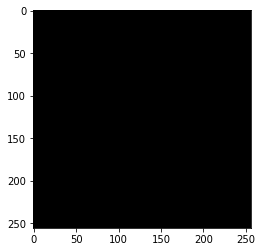

In [4]:
blank_image = np.zeros(shape=(HEIGHT, WIDTH, CHANNELS))

plt.imshow(blank_image)

# Draw rectangles

Note: This will be useful when we want to draw bounding boxes too!

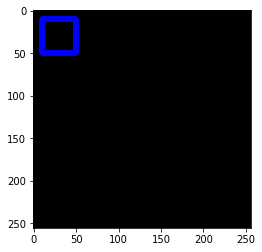

In [5]:
# Draw a rectangle on the blank image
cv2.rectangle(blank_image, pt1=(10, 10), pt2=(50, 50), color=(0, 0, 255), thickness=5)

plt.imshow(blank_image / 255.0)

# Draw circles

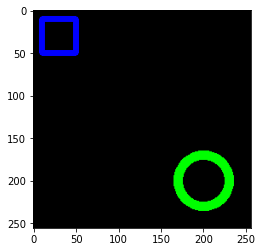

In [6]:
cv2.circle(blank_image, center=(200, 200), radius=30, color=(0, 255, 0), thickness=10)

plt.imshow(blank_image / 255.0)

# Draw Triangles

Or any polygon by just defining more points.

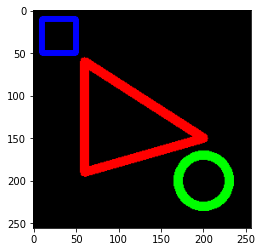

In [7]:
# Each point is a corner of the triangle
# If you add more points, you can get more complex polygons.
pts = [(60, 60), (60, 190), (200, 150)]

cv2.polylines(blank_image, np.array([pts]), True, color=(255, 0, 0), thickness=10)

plt.imshow(blank_image / 255.0)

# Let's write some methods to draw our shapes

This way we can reuse them later for our dataset.

In [8]:
def create_blank(
    height: int = HEIGHT, width: int = WIDTH, channels: int = CHANNELS
) -> np.ndarray:
    """Create an empty image (all black)

    Args:
        height (int): Image height
        width (int): Image width
        channels (int): Image channels (usually 3 for RGB)
    """

    # Return an empty image
    return np.zeros(shape=(height, width, channels))

In [9]:
def create_shape(img: np.ndarray, shape_type: str) -> np.ndarray:
    """Create circle, rectangle, or triangle

    Overlays the shape onto the image img

    Args:
        img(np.ndarray): The original image
        shape_type(str): A string "rectangle", "circle", or "triangle"

    Returns:
        An image with the shape(s) overlaid on the original input image

    """

    thickness = np.random.randint(2, 10)

    BLUE = (0, 0, 255)
    GREEN = (0, 255, 0)
    RED = (255, 0, 0)

    if shape_type == "rectangle":

        max_width = 60
        left = np.random.randint(img.shape[0] - max_width)
        width = np.random.randint(20, max_width)
        right = left + width

        max_height = 60
        bottom = np.random.randint(img.shape[1] - max_height)
        height = np.random.randint(20, max_height)
        top = bottom + height

        cv2.rectangle(
            img, pt1=(left, bottom), pt2=(right, top), color=BLUE, thickness=thickness
        )

    elif shape_type == "circle":

        center_x = np.random.randint(img.shape[0] // 2 - 30, img.shape[0] // 2 + 30)
        center_y = np.random.randint(img.shape[1] // 2 - 30, img.shape[1] // 2 + 30)
        radius = np.random.randint(20, img.shape[1] // 3)

        cv2.circle(
            img,
            center=(center_x, center_y),
            radius=radius,
            color=GREEN,
            thickness=thickness,
        )

    elif shape_type == "triangle":

        # Each point is in a different quadrant
        pt1 = (
            np.random.randint(thickness + 1, img.shape[0] // 2),
            np.random.randint(thickness + 1, img.shape[1] // 2),
        )
        pt2 = (
            np.random.randint(
                img.shape[0] // 2 + thickness + 1, img.shape[0] - (thickness + 1)
            ),
            np.random.randint(
                img.shape[1] // 2 + thickness + 1, img.shape[1] - (thickness + 1)
            ),
        )

        pt3 = (
            np.random.randint(
                img.shape[0] // 2 + thickness + 1, img.shape[0] - (thickness + 1)
            ),
            np.random.randint(thickness + 1, img.shape[1] // 2 - thickness + 1),
        )

        pts = [pt1, pt2, pt3]

        cv2.polylines(img, np.array([pts]), True, RED, thickness=thickness)

    else:
        # Shape is unknown
        raise ValueError

    return img / img.max()  # Normalize between 0 and 1

In [10]:
def random_shapes(shapes:list[str]) -> np.ndarray:
    """Create an image with random_shapes
    
    Args:
        A list of strings containing shape names to add to the image.
        
    Returns:
        An image with the specified shapes.
    """
    
    img = create_blank()
    
    for shape in shapes:
        
        create_shape(img, shape) 
        
    return img / img.max()  # Normalize between 0 and 1
        

# create_shape

Creates a blank image with this shape

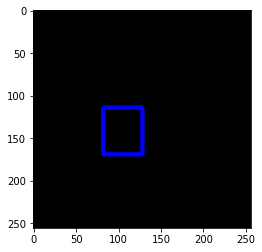

In [11]:
plt.imshow(create_shape(create_blank(), "rectangle"))

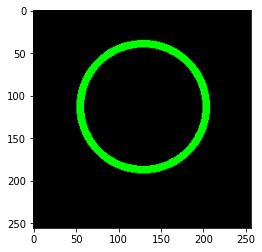

In [12]:
plt.imshow(create_shape(create_blank(), "circle"))

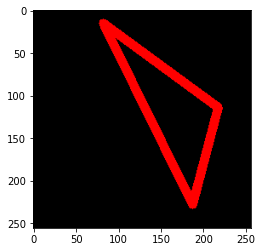

In [13]:
plt.imshow(create_shape(create_blank(), "triangle"))

# random_shapes

Create an image with a list of random shapes.

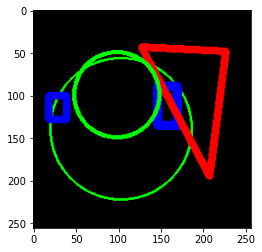

In [14]:
plt.imshow(random_shapes(["circle", "rectangle", "rectangle", "triangle", "circle"]))

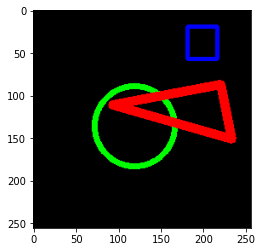

In [15]:
plt.imshow(random_shapes(["circle", "triangle", "rectangle"]))

# Creating the TensorFlow data loader

Dataloaders are essential. We need to create them because typically our entire dataset will *not* fit into RAM. A dataloader allows us to load (and augment) data at the time it is needed for the time it is needed.

In [16]:
import tensorflow as tf

## Define a Python function that can be used in tf.data

We just use the same `random_shapes` Python function that we defined previously. So we are calling OpenCV from Python within TensorFlow. If we need to do any random flips/rotations/crops, then we can do so here as well.

In [17]:
def tf_shapes(n):
    """Return a random shape for the tf.data dataloader

    Args:
        n(int): 0=circle, 1=rectangle, 2=triangle

    Output:
        Image with shape, shape index
    """

    img = random_shapes(list([class_names[n.numpy()]])).astype(np.float32)

    img = tf.reshape(img, [1, HEIGHT, WIDTH, CHANNELS])

    class_num = tf.reshape(n,[1,])

    return img, class_num

## Define a random array of [0, 1, 2] that is n_data in length

In [18]:
n_data = 1000

random_ints = np.random.randint(0, high=len(class_names), size=[n_data,], dtype=np.int32)

## We can use `map` to change the random numbers into images

In [19]:
ds = tf.data.Dataset.from_tensor_slices(random_ints)

ds = ds.map(lambda x: tf.py_function(tf_shapes, [x], [tf.float32, tf.int32]))

# Test the TensorFlow dataloader
 
Let's print out a few random images

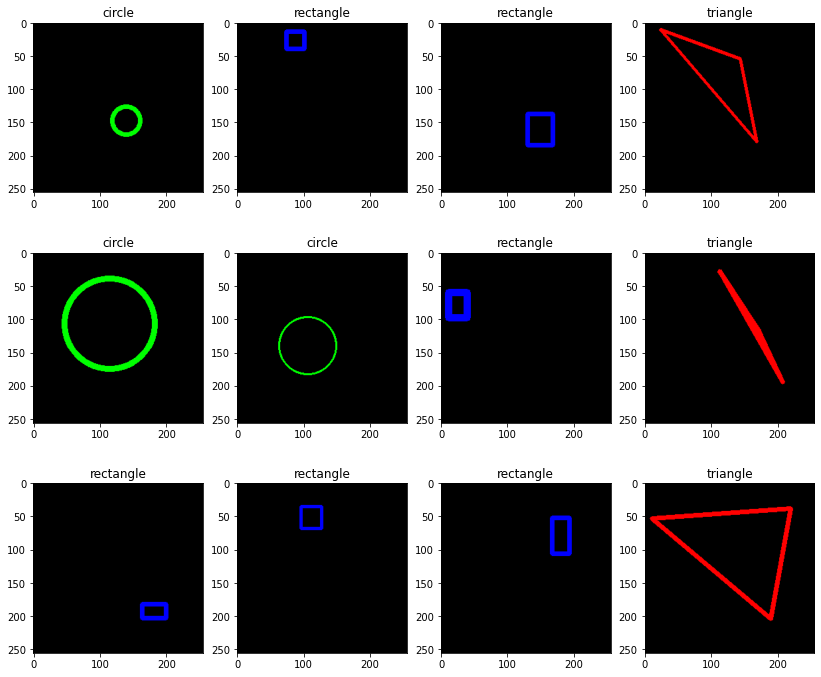

In [20]:
rows = 3
cols = 4

plt.figure(figsize=(14, 12))

for idx, data in enumerate(ds.take(rows * cols)):

    img, class_num = data[0][0], data[1][0]
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(img)
    plt.title(class_names[class_num])

## Define a simple CNN classification model

This is like the CNN classification models that we've seen before. The key differences:
* It has a [Global Average Pooling](https://paperswithcode.com/method/global-average-pooling#:~:text=Global%20Average%20Pooling%20is%20a,in%20the%20last%20mlpconv%20layer.)
* It has [sparse output](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) (i.e. not one-hot encoded)

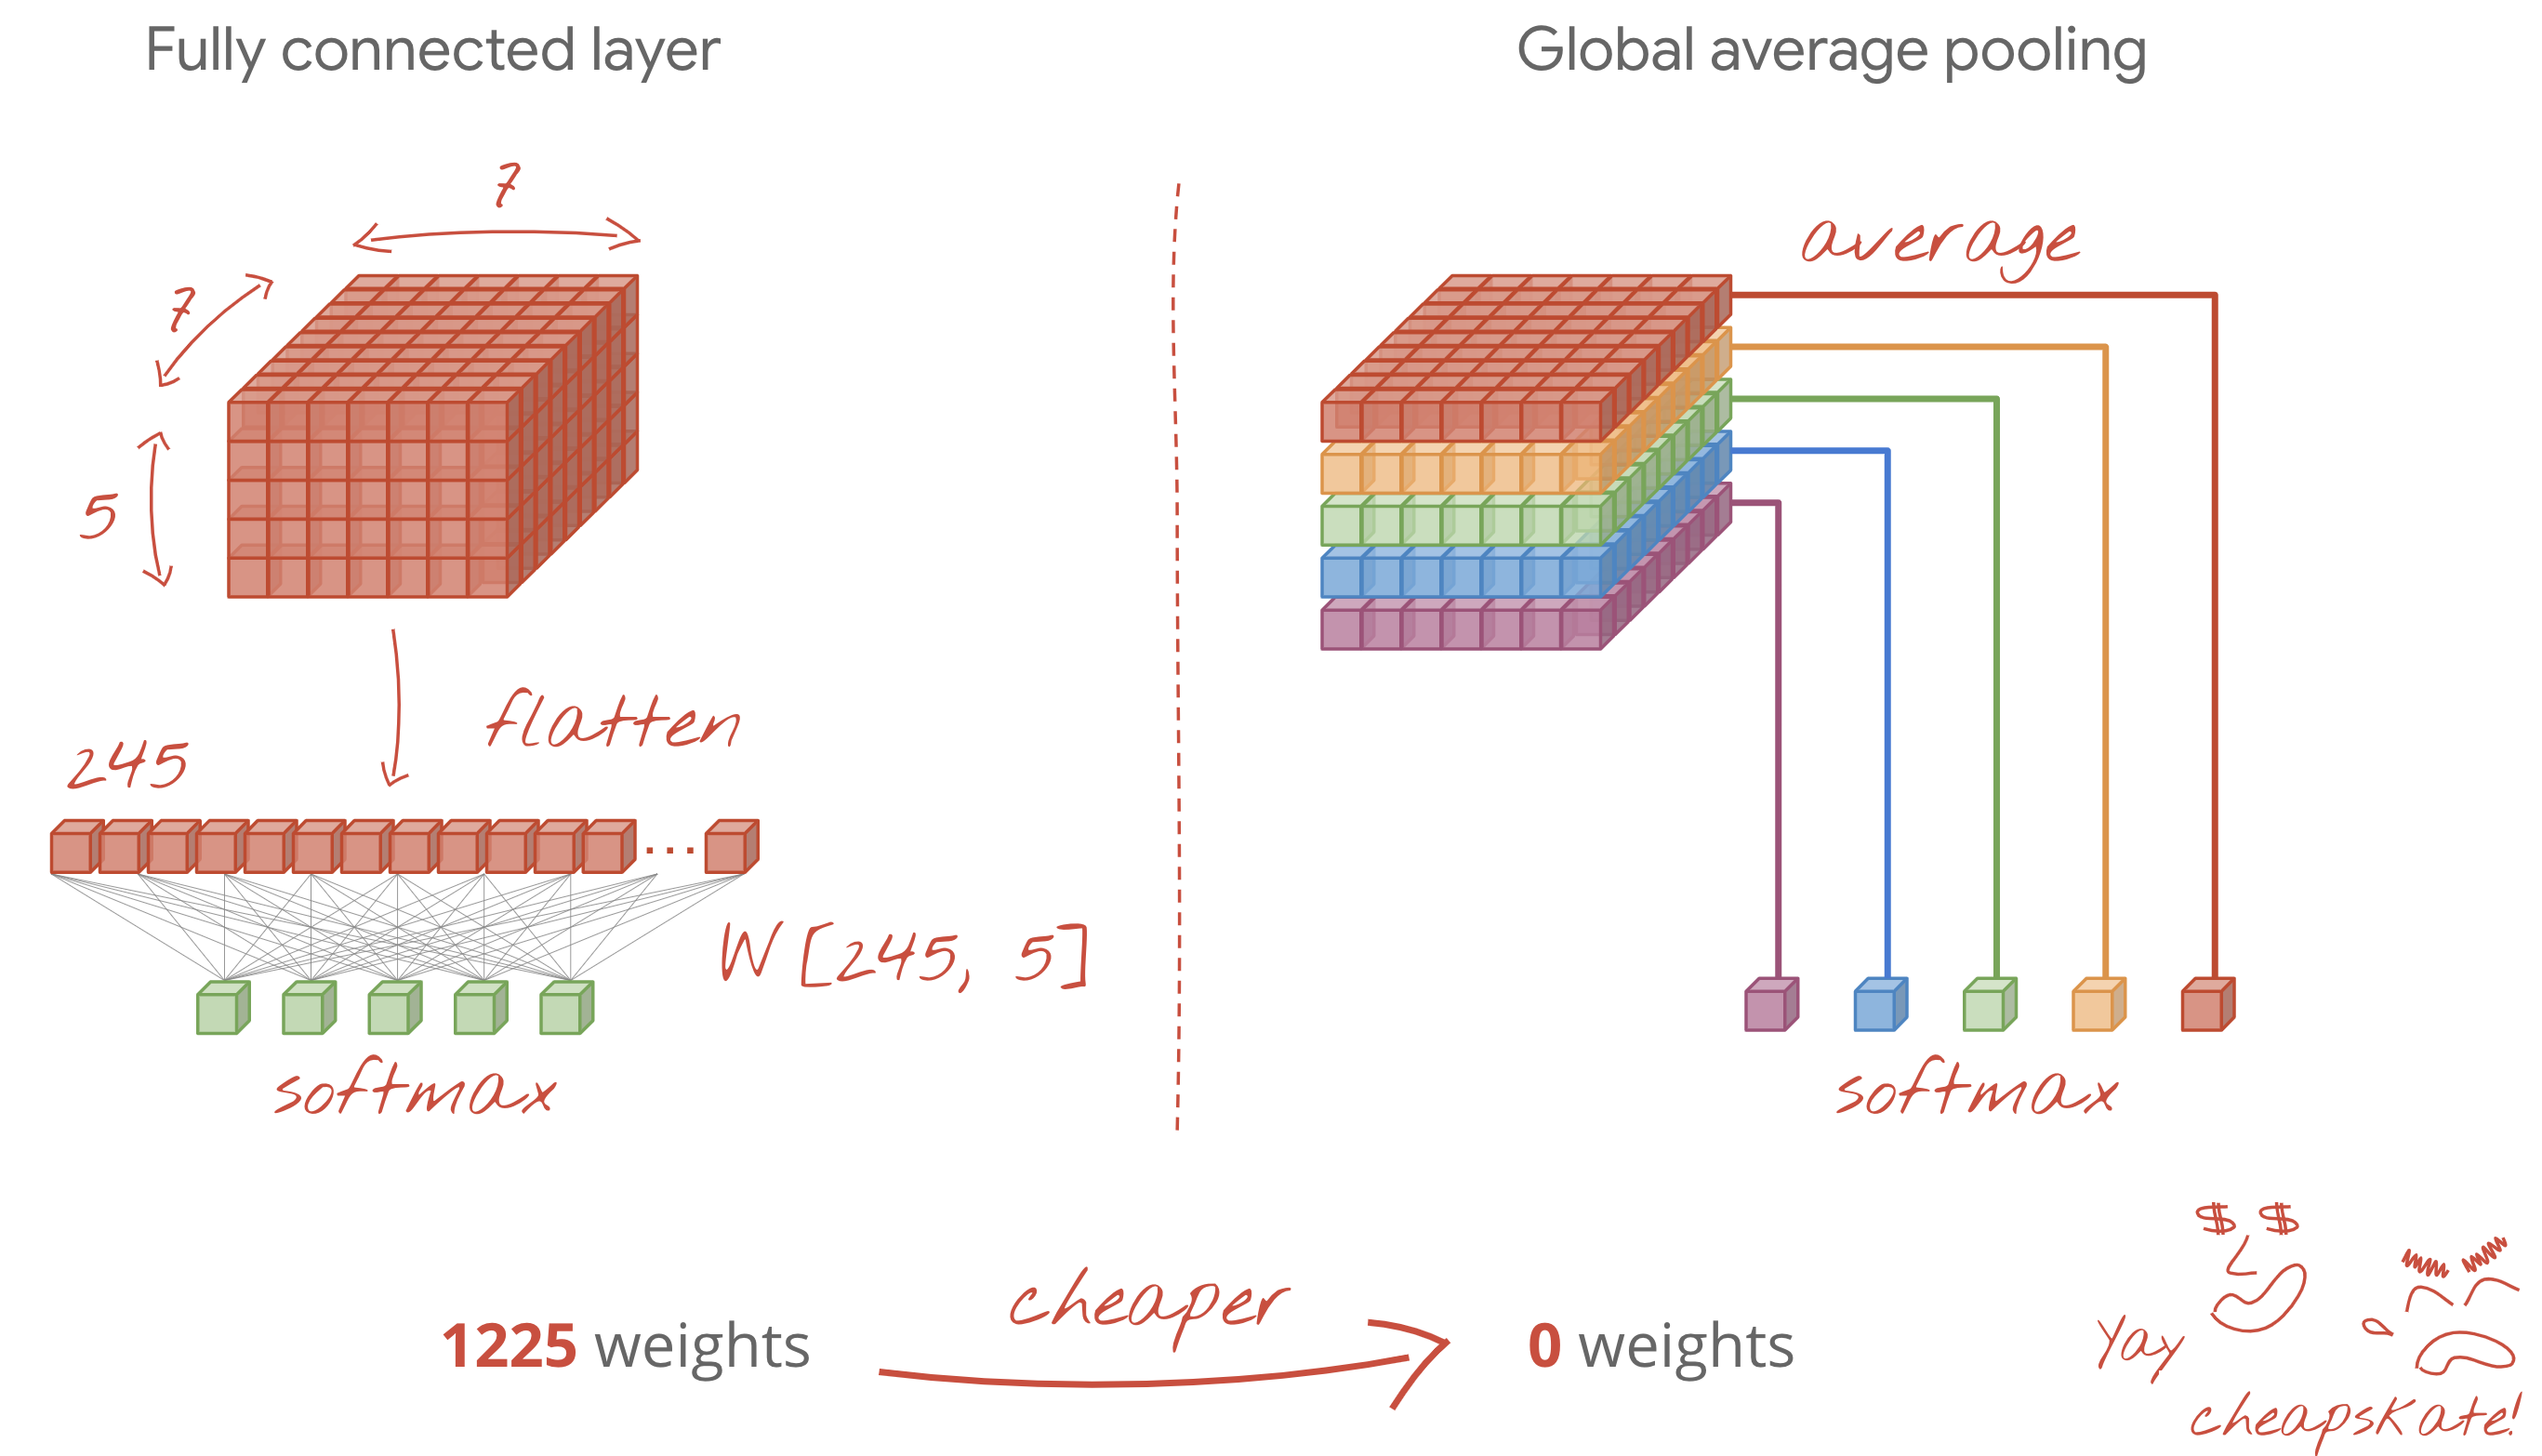
(Source: https://codelabs.developers.google.com/codelabs/keras-flowers-tpu#0)

In [21]:
def simple_cnn_classifier():
    """Simple convolutional neural network

    NOTE: The use of GlobalAveragePool2D and Sparse
    NOTE: The None trick is used to define the shape!
    """

    inputs = tf.keras.layers.Input(shape=(None, None, CHANNELS))

    conv1 = tf.keras.layers.Conv2D(
        filters=16, kernel_size=(3, 3), activation="relu", padding="same"
    )(inputs)
    conv2 = tf.keras.layers.Conv2D(
        filters=11, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv1)

    pool1 = tf.keras.layers.MaxPool2D()(conv2)

    conv3 = tf.keras.layers.Conv2D(
        filters=17, kernel_size=(3, 3), activation="relu", padding="same"
    )(pool1)
    conv4 = tf.keras.layers.Conv2D(
        filters=8, kernel_size=(3, 3), activation="relu", padding="same"
    )(conv3)

    pool2 = tf.keras.layers.MaxPool2D()(conv4)

    conv5 = tf.keras.layers.Conv2D(
        filters=14, kernel_size=(3, 3), activation="relu", padding="same"
    )(pool2)

    # This is the actual sparse layer
    # We don't use an activation layer
    # Therefore, the numbers can be any real number
    # We'll just take the argmax to get the correct prediction
    # This removes the need for a softmax (and one-hot encoding)
    # Save us time and layers!
    conv6 = tf.keras.layers.Conv2D(
        filters=len(class_names), kernel_size=(3, 3), activation=None, padding="same"
    )(conv5)

    # A new layer Global Average Pooling
    # This averages across the channels
    # Makes the model fully-convolutional so it is image size agnostic
    global_pool1 = tf.keras.layers.GlobalAveragePooling2D()(conv6)

    model = tf.keras.models.Model(inputs=[inputs], outputs=[global_pool1])

    return model

In [22]:
model = simple_cnn_classifier()

model.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, None, None, 3)]                         0                 
                                                                                                                        
 conv2d (Conv2D)                                      (None, None, None, 16)                          448               
                                                                                                                        
 conv2d_1 (Conv2D)                                    (None, None, None, 11)                          1595              
                                                                                                                        
 max_pooling2d (M

In [23]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
)

## Split tf dataset into train and validation

Of course, you could split out a testing dataset as well in the same way.

In [24]:
n_train = int(n_data * 0.80)  # 80 / 20 split
ds_train = ds.take(n_train)

ds_remain = ds.skip(n_train)

n_remain = (n_data - n_train) // 2  # 50/50 split
ds_val = ds_remain.take(n_remain)
ds_test = ds_remain.skip(n_remain)

## Train the model

Sparse categorical accuracy goes from 0 (bad) to 1 (perfect) predictions.

In [25]:
model.fit(ds_train, batch_size=64, epochs=2, validation_data=ds_val)

Epoch 1/2
800/800 [==============================] - 55s 68ms/step - loss: 0.7312 - sparse_categorical_accuracy: 0.6400 - val_loss: 0.3655 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/2
800/800 [==============================] - 56s 70ms/step - loss: 0.3255 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1365 - val_sparse_categorical_accuracy: 1.0000


## Evaluate the trained model on the holdout test dataset

This should be data the model never saw during training nor validation.

In [26]:
loss, accuracy = model.evaluate(ds_test)

print(f"The model is {accuracy*100:.1f}% accurate on the holdout test dataset.")

100/100 [==============================] - 3s 14ms/step - loss: 0.1168 - sparse_categorical_accuracy: 1.0000
The model is 100.0% accurate on the holdout test dataset.


## Make some predictions of new random images based on our trained model

In [27]:
def make_prediction(shape_name: str):
    """Make predictions on the trained model

    Args:
        shape_name(str) : "circle", "rectangle", "triangle"

    Returns:
        Input image and the predicted shape
    """

    img = random_shapes([shape_name])
    plt.imshow(img)

    prediction = np.argmax(model.predict(np.expand_dims(img, 0)))
    plt.title(class_names[prediction])

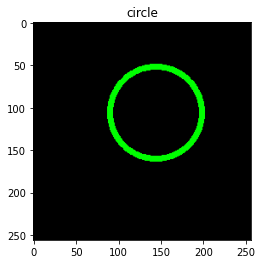

In [28]:
make_prediction("circle")

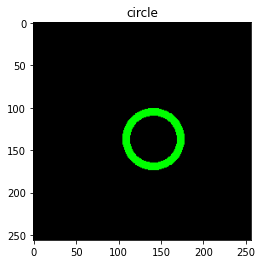

In [29]:
make_prediction("circle")

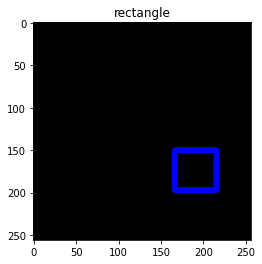

In [30]:
make_prediction("rectangle")

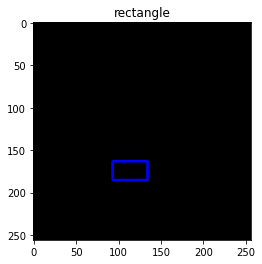

In [31]:
make_prediction("rectangle")

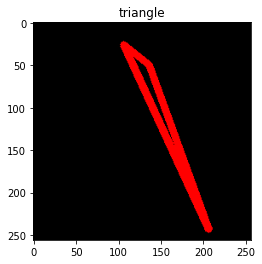

In [32]:
make_prediction("triangle")

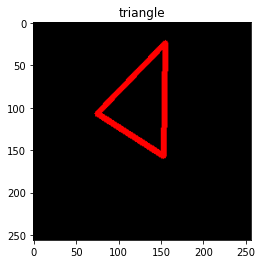

In [33]:
make_prediction("triangle")

## Will it work with other image sizes?

Yes. Thanks to a fully convolutional network and the `None` shape trick.

Text(0.5, 1.0, 'circle')

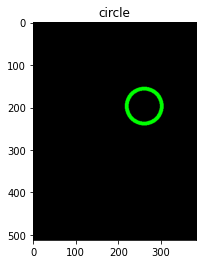

In [34]:
img = create_shape(create_blank(height=512, width=384, channels=3), "circle")

plt.imshow(img)

plt.title(class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])

Text(0.5, 1.0, 'triangle')

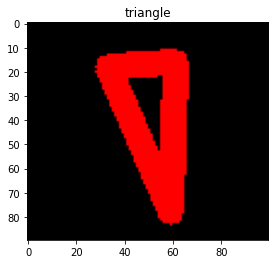

In [35]:
img = create_shape(create_blank(height=90, width=100, channels=3), "triangle")

plt.imshow(img)

plt.title(class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])

Text(0.5, 1.0, 'rectangle')

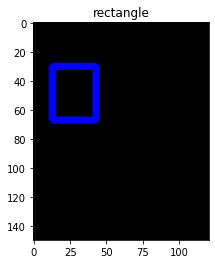

In [36]:
img = create_shape(create_blank(height=150, width=121, channels=3), "rectangle")

plt.imshow(img)

plt.title(class_names[np.argmax(model.predict(np.expand_dims(img, 0)))])